<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/415_reglin_4.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(causal-inference-notebook)=
# Inferenza causale

Lo scopo di questo capitolo è di introdurre il modello di regressione multipla e di discutere come esso si collega all'inferenza causale bayesiana. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import statistics as st
import arviz as az
import bambi as bmb
import pymc as pm
from pymc import HalfNormal, Model, Normal, sample
import networkx as nx
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

ModuleNotFoundError: No module named 'networkx'

In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 12345
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

## Regressione multipla

Il modello di regressione multipla estende il modello di regressione bivariato includendo più predittori nel modello. In questa situazione, la variabile dipendente $\hat{Y}_i$ viene predetta tenendo conto della presenza di $k$ predittori: $X_1, X_2, \dots, X_k$. Il modello di regressione multipla assume che il valore atteso di $\hat{Y}_i$ condizionato a $X_1, X_2, \dots, X_k$ sia descritto da un'equazione lineare: $\hat{Y}_i \mid X_1, X_2, \dots, X_k = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_k X_k$. In questa formulazione, i coefficienti $\beta_j$ rappresentano i *coefficienti parziali di regressione* e riflettono la relazione tra la variabile dipendente e ciascuna delle variabili indipendenti, considerando anche l'effetto delle altre variabili presenti nel modello.

La differenza chiave rispetto al modello di regressione bivariato sta nell'interpretazione dei coefficienti. Nel caso bivariato, il coefficiente $\beta$ viene interpretato come il cambiamento atteso nella variabile dipendente $Y$ al variare di una unità nella variabile indipendente $X$. Tuttavia, nel modello di regressione multipla, l'interpretazione di $\beta_j$ cambia. In questo caso, $\beta_j$ rappresenta il cambiamento atteso nella variabile dipendente $Y$ al variare di una unità nella variabile $X_j$, *mantenendo costanti gli effetti delle altre variabili $X$ nel modello*. In altre parole, se aumentiamo $X_j$ di una unità, mantenendo costanti gli altri predittori, il coefficiente $\beta_j$ rappresenta il cambiamento atteso in $Y$. Tuttavia, in generale, al variare di $X_j$, anche le altre variabili $X$ possono variare e, in queste circostanze, $\beta_j$ rappresenta il cambiamento atteso di $Y$ al variare di $X_j$, dopo aver rimosso l'effetto lineare delle altre variabili indipendenti sia da $Y$ che da $X_j$.

## Interpretazione del modello

Il modello di regressione multipla viene utilizzato per due scopi principali. In primo luogo, è impiegato per la predizione, ovvero per ottenere la migliore stima possibile della variabile dipendente $Y$ utilizzando una combinazione lineare dei predittori $X_1, X_2, \dots, X_k$. In questo contesto, i coefficienti parziali di regressione sono considerati semplicemente come pesi che consentono di ottenere la migliore previsione di $Y$.

In secondo luogo, il modello di regressione multipla viene spesso utilizzato per descrivere le relazioni causali tra le variabili, un'applicazione comune in psicologia. Tuttavia, è importante sottolineare che l'utilizzo di questo modello per scopi causali può essere problematico. Il modello di regressione è unicamente uno strumento statistico e non è stato appositamente costruito per stabilire relazioni causali tra le variabili. Pertanto, attribuire una interpretazione causale diretta ai coefficienti parziali di regressione ("se $X$ aumenta di un'unità, allora $Y$ aumenta in media di $\beta_j$ punti, al netto dell'effetto delle altre variabili") può portare a risultati fuorvianti.

Infatti, è stato dimostrato che il modello di regressione multipla stima correttamente i coefficienti parziali di regressione solo in una situazione particolare, ovvero quando tutte le variabili che hanno un effetto causale su $Y$ sono incluse nel modello. Tuttavia, nella pratica, i ricercatori spesso non conoscono tutte le variabili causalmente rilevanti per $Y$ e quindi questa condizione non può essere soddisfatta.

Nonostante queste limitazioni, il modello di regressione multipla rimane uno strumento utile, poiché può fornire una rappresentazione approssimata delle relazioni causali tra le variabili considerate. Tuttavia, è fondamentale essere consapevoli del problema dell'errore di specificazione, che si verifica quando una variabile influente su $Y$ non è inclusa nel modello di regressione e può portare a distorsioni nei risultati delle stime dei coefficienti parziali di regressione. Se una nuova variabile $X$, che influenza $Y$, viene successivamente identificata e non era stata considerata inizialmente, la rappresentazione delle relazioni causali potrebbe dover essere completamente rivista, con possibili cambiamenti sia nell'intensità che nel segno delle stime dei coefficienti parziali di regressione.

Il presente capitolo mira a fornire un esempio di come la conoscenza delle reali relazioni causali tra le variabili possa condurre a una migliore specificazione del modello di regressione, evitando così distorsioni nelle stime dei coefficienti di regressione. In queste specifiche circostanze, le stime dei coefficienti risulteranno accurate e coerenti con le vere relazioni di causa-effetto.

## Simulazione

Prima di tutto, genereremo dei dati compatibili con il seguente Grafo Aciclico Diretto (DAG) causale. Per mantenere le cose semplici, tutti i nodi nel grafo hanno una distribuzione normale e le relazioni tra i nodi sono lineari. Un Causal DAG (Grafo Aciclico Diretto) è un grafo aciclico diretto, ovvero un modello grafico utilizzato per rappresentare le relazioni causali tra le variabili. Nel DAG, i nodi rappresentano le variabili e gli archi diretti indicano la direzione della causa-effetto tra le variabili. 

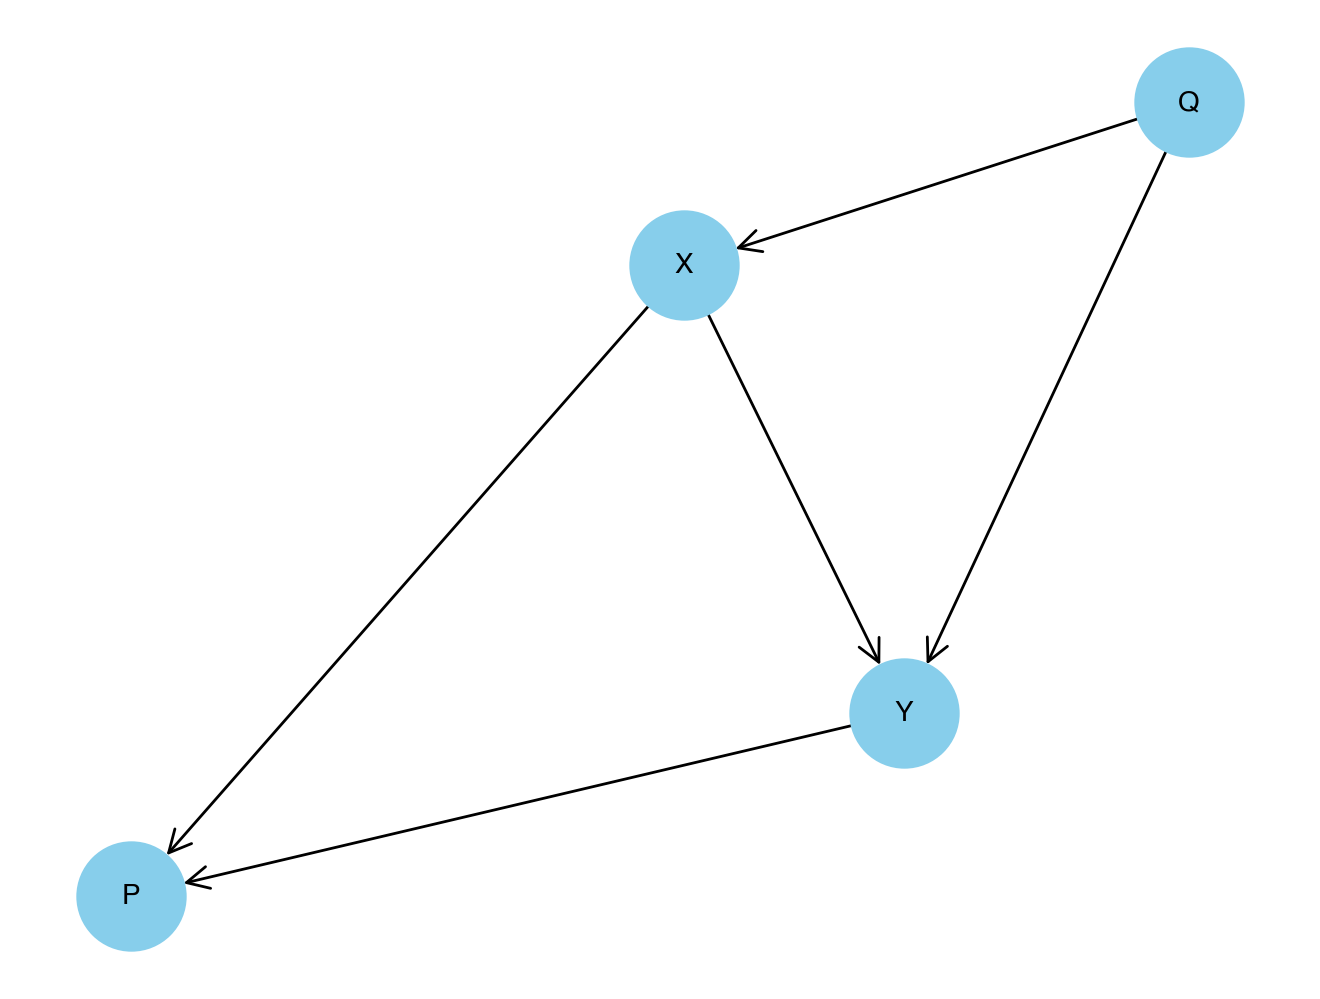

In [5]:
graph = nx.DiGraph()
#graph.add_edges_from([("root", "a"), ("a", "b"), ("a", "e"), ("b", "c"), ("b", "d"), ("d", "e")])
graph.add_edges_from([("X", "Y"), ("X", "P"), ("Y", "P"), ("Q", "X"), ("Q", "Y")])

# Draw the graph
pos = nx.spring_layout(graph, seed=42)  # Position nodes using spring layout algorithm
nx.draw(graph, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20, arrowstyle="->")
plt.show()

Siamo principalmente interessati alla relazione tra due variabili, chiamate X e Y. Tuttavia, dobbiamo considerare la presenza di una variabile confondente, indicata come Q, che ha un'influenza sia su X che su Y. Inoltre, il DAG introduce un altro concetto, chiamato collider, rappresentato da P, che è una variabile influenzata sia da X che da Y. In sintesi, nella nostra analisi dobbiamo prendere in considerazione la presenza di queste variabili confondenti e collider, poiché possono influenzare i risultati e complicare la comprensione della relazione tra X e Y.

Generiamo un dataset simulato di 5000 osservazioni e osserviamo le prime 5. 

In [6]:
N = 5_000
Q = rng.normal(size=N)
X = rng.normal(loc=0.14*Q, scale=0.4, size=N)
Y = rng.normal(loc=0.7*X + 0.11*Q, scale=0.24, size=N)
P = rng.normal(loc=0.43*X + 0.21*Y, scale=0.22, size=N)
df = pd.DataFrame({"Q": Q, "X": X, "Y": Y, "P": P})

df.head()

,Q,X,Y,P
0,0.304717,-0.060520,0.033461,0.185277
1,-1.039984,-0.265392,-0.084383,0.079660
2,0.750451,-0.173601,-0.392316,0.007946
3,0.940565,0.303072,0.247141,0.279045
4,-1.951035,-0.179286,-0.141118,-0.015906


Si noti che abbiamo specificato un vero effetto causale tra X e Y pari a 0.7. Di seguito vedremo quanto accuratamente possiamo recuperare questo valore utilizzando diverse approcci.

## Approccio 1

Ciò che ci interessa è la relazione tra X e Y. Anche se può sembrare una semplificazione, è abbastanza comune stimare direttamente questa relazione. Possiamo costruire un modello per fare questo utilizzando `bambi`` (Capretto et al. 2022) con la nota notazione delle formule, Y ~ X (Wilkinson e Rogers 1973).

In [7]:
model = bmb.Model("Y ~ X", df)
results = model.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:05.752849
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]





Running chain 0:  40%|████      | 800/2000 [00:03<00:00, 7549.38it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 532.12it/s] 


Sampling time =  0:00:04.163399
Transforming variables...
Transformation time =  0:00:00.024047
Computing Log Likelihood...
Log Likelihood time =  0:00:01.302219


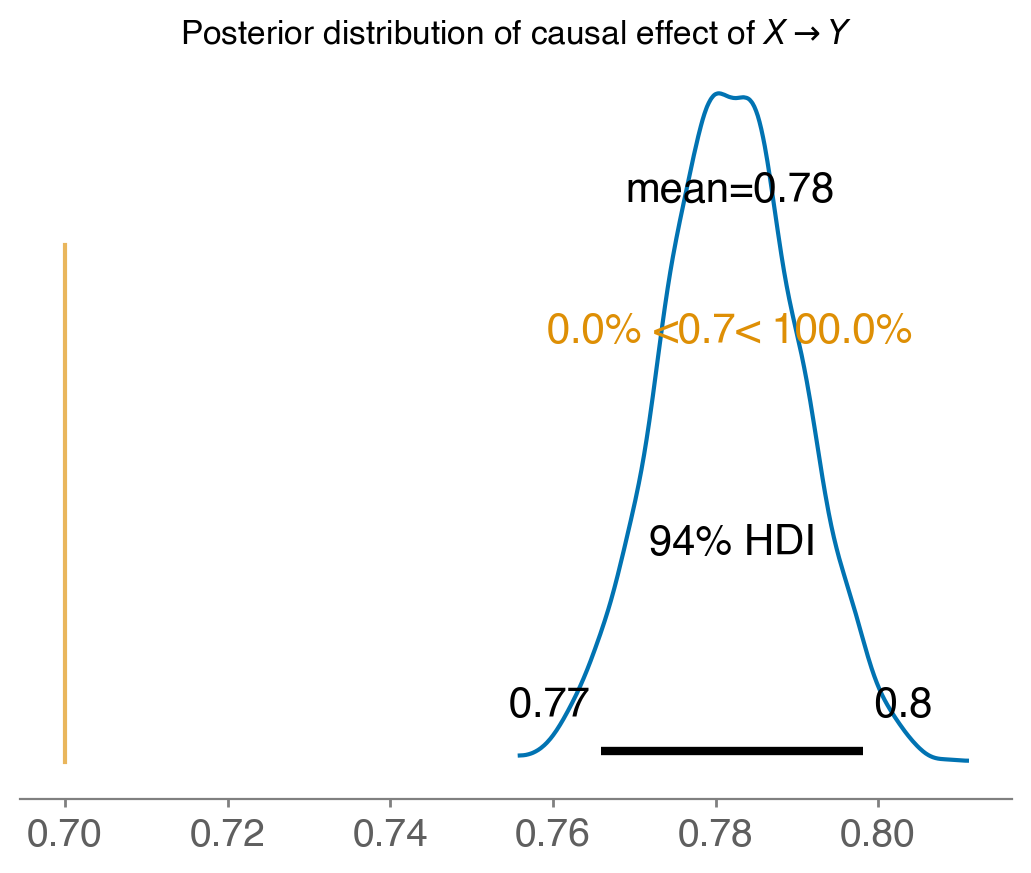

In [8]:
ax = az.plot_posterior(results.posterior["X"], ref_val=0.7)
ax.set_title(r"Posterior distribution of causal effect of $X \rightarrow Y$");

Notiamo che la nostra stima dell'influenza causale di X sulla Y è molto distante dal valore reale. Ciò non sorprenderà gran parte delle persone con una formazione statistica, poiché non abbiamo considerato nessuna delle altre variabili presenti nel nostro dataset.

## Approccio 2

Quindi proviamo a correggere questa situazione. Questa volta includeremo tutte le variabili nel modello di regressione. Questo è un approccio molto comune ed è stato chiamato "l'insalata causale" (vedi McElreath 2020; anche Bulbulia et al. 2021). L'idea alla base è che, includendo tutte le variabili nel modello di regressione, possiamo osservare l'effetto di X su Y dopo aver tenuto conto di tutte le altre variabili. Sembra ragionevole. Vediamo ora quanto bene funziona questo approccio nel caso presente.

In [9]:
model = bmb.Model("Y ~ Q + X + P", df)
results = model.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:01.787911
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 0:  10%|█         | 200/2000 [00:03<00:00, 1896.36it/s]


Running chain 0:  25%|██▌       | 500/2000 [00:04<00:00, 2296.93it/s]


Running chain 0:  45%|████▌     | 900/2000 [00:04<00:00, 2818.16it/s]




Running chain 0:  65%|██████▌   | 1300/2000 [00:04<00:00, 2948.32it/s]



Running chain 0:  85%|████████▌ | 1700/2000 [00:04<00:00, 2986.32it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:04<00:00, 430.54it/s] 


Sampling time =  0:00:04.847288
Transforming variables...
Transformation time =  0:00:00.009163
Computing Log Likelihood...
Log Likelihood time =  0:00:01.025117


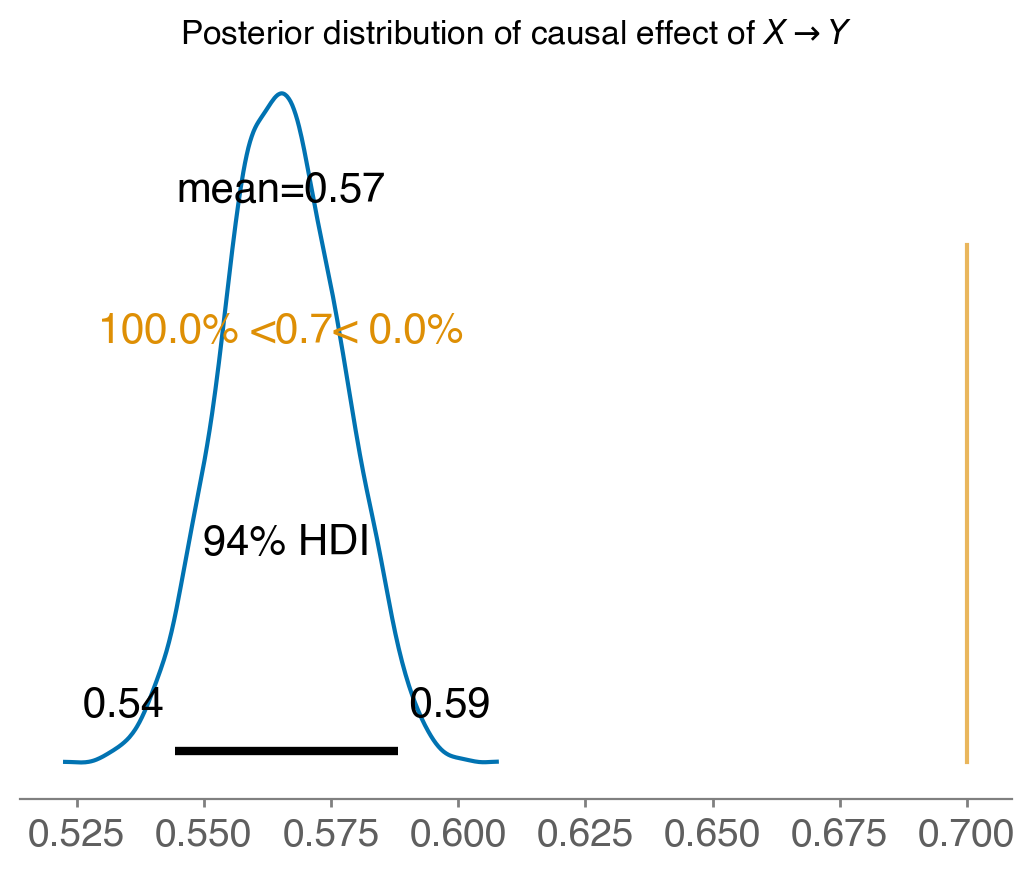

In [10]:
ax = az.plot_posterior(results.posterior["X"], ref_val=0.7)
ax.set_title(r"Posterior distribution of causal effect of $X \rightarrow Y$");

Questo è persino peggio rispetto a prima. Cosa sta succedendo? Il problema è che abbiamo incluso sia controlli validi che controlli non validi nella nostra regressione. Ma come si possono distinguere i controlli validi da quelli non validi?

## Approccio 3: solo controlli validi

Una risposta alla domanda precedente che si applica al caso presente è che, riguardo al DAG presentato in precedenza, si configura una via backdoor tra X e Y attraverso Q. Ciò implica che esiste un percorso statistico in cui X può influenzare Y tramite Q. Quando si ha una via backdoor, è necessario bloccarla. Ciò può essere realizzato includendo Q nella nostra regressione. In questo modo, Q diventa un buon controllo capace di mitigare gli effetti confondenti di Q e ottenere stime più accurate dell'influenza di X su Y.

In [11]:
model = bmb.Model("Y ~ X + Q", df)
results = model.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:04.346472
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]




Running chain 0:  20%|██        | 400/2000 [00:03<00:00, 3420.26it/s]


Running chain 0:  50%|█████     | 1000/2000 [00:03<00:00, 4651.48it/s]


Running chain 0:  80%|████████  | 1600/2000 [00:03<00:00, 4988.44it/s]



Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 555.15it/s] 


Sampling time =  0:00:03.787743
Transforming variables...
Transformation time =  0:00:00.009396
Computing Log Likelihood...
Log Likelihood time =  0:00:00.861773


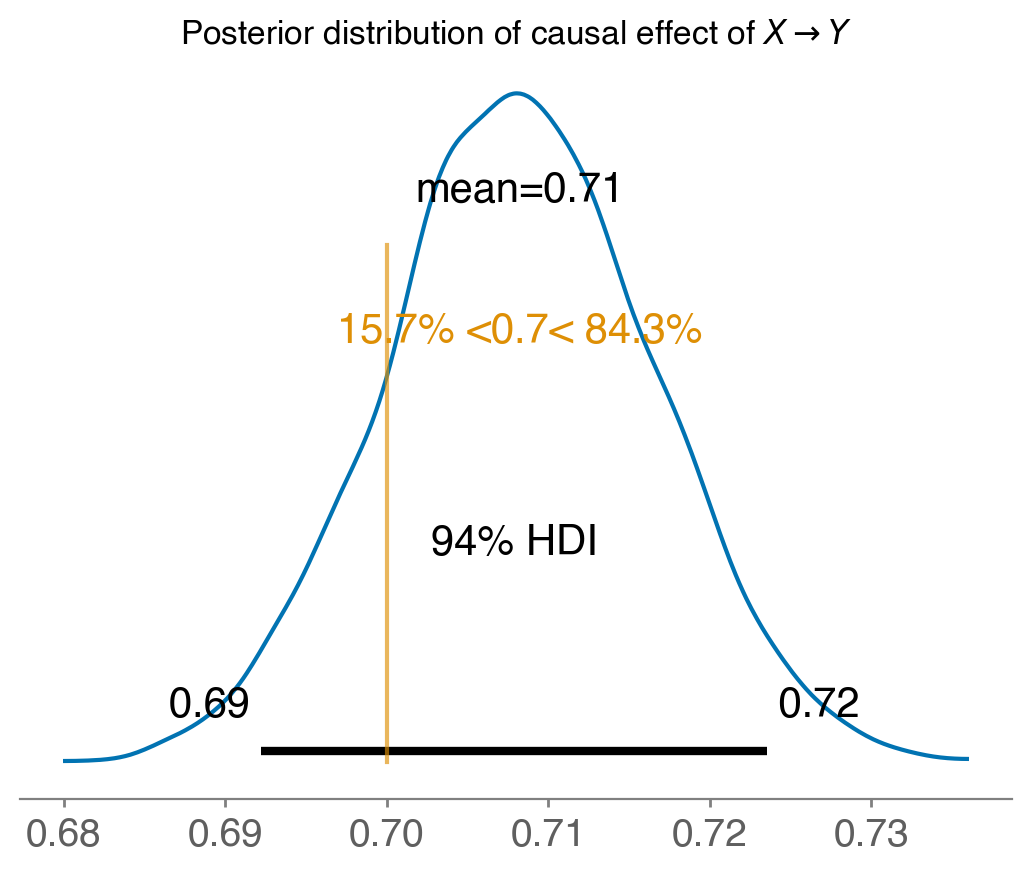

In [12]:
ax = az.plot_posterior(results.posterior["X"], ref_val=0.7)
ax.set_title(r"Posterior distribution of causal effect of $X \rightarrow Y$");

Abbiamo recuperato il vero effetto causale di X. Abbiamo ottenuto questo risultato includendo solo i "buoni" controlli nel modello di regressione.

## Approccio del Modello Causale Strutturale Bayesiano

In alternativa, è possibile specificare tutta la struttura causale descritta dal DAG in un modello bayesiano.

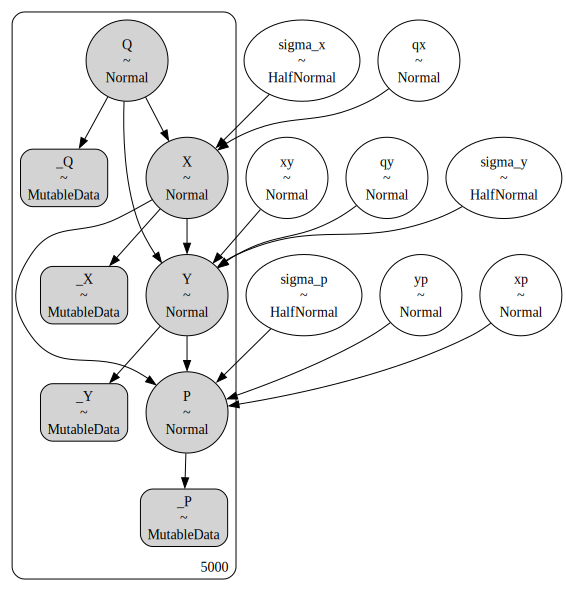

In [13]:
with pm.Model() as model:
    # data
    _Q = pm.MutableData("_Q", df["Q"])
    _X = pm.MutableData("_X", df["X"])
    _Y = pm.MutableData("_Y", df["Y"])
    _P = pm.MutableData("_P", df["P"])

    # priors on slopes
    # x ~ q
    qx = pm.Normal("qx")
    # y ~ x + q
    xy = pm.Normal("xy")
    qy = pm.Normal("qy")
    # p ~ x + y
    xp = pm.Normal("xp")
    yp = pm.Normal("yp")

    # priors on sd's
    sigma_x = pm.HalfNormal("sigma_x")
    sigma_y = pm.HalfNormal("sigma_y")
    sigma_p = pm.HalfNormal("sigma_p")
    
    # model
    Q = pm.Normal("Q", observed=_Q)
    X = pm.Normal("X", mu=qx*Q, sigma=sigma_x, observed=_X)
    Y = pm.Normal("Y", mu=xy*X + qy*Q, sigma=sigma_y, observed=_Y)
    P = pm.Normal("P", mu=xp*X + yp*Y, sigma=sigma_p, observed=_P)

pm.model_to_graphviz(model)

In [15]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:15.812649
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:04<?, ?it/s]



Running chain 0:  10%|█         | 200/2000 [00:04<00:01, 1316.90it/s]




Running chain 0:  25%|██▌       | 500/2000 [00:04<00:00, 1728.32it/s]


Running chain 0:  40%|████      | 800/2000 [00:04<00:00, 1963.48it/s]


Running chain 0:  55%|█████▌    | 1100/2000 [00:05<00:00, 2023.12it/s]


Running chain 0:  70%|███████   | 1400/2000 [00:05<00:00, 2061.16it/s]


Running chain 0:  85%|████████▌ | 1700/2000 [00:05<00:00, 2044.02it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:05<00:00, 361.43it/s] 


Sampling time =  0:00:05.783807
Transforming variables...
Transformation time =  0:00:00.016789
Computing Log Likelihood...
Log Likelihood time =  0:00:04.321621


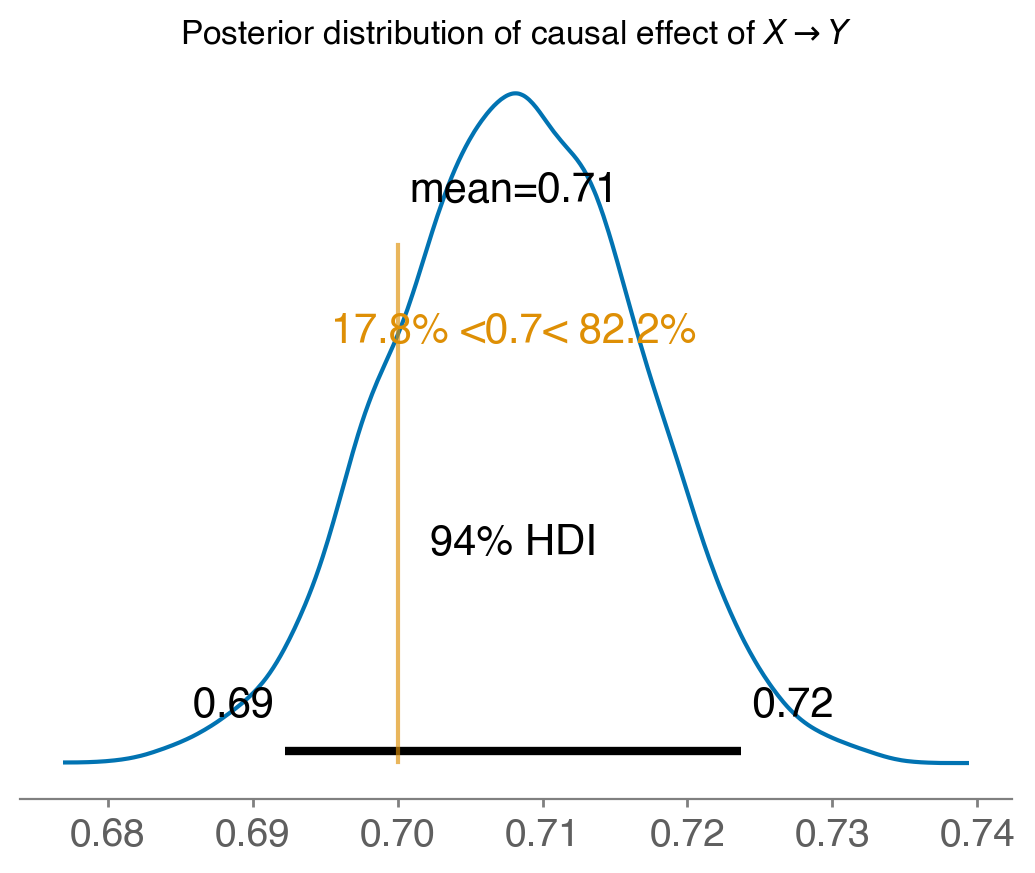

In [16]:
ax = az.plot_posterior(idata, var_names="xy", ref_val=0.7)
ax.set_title(r"Posterior distribution of causal effect of $X \rightarrow Y$");

In questa situazione, siamo riusciti a recuperare il vero effetto causale di X, ma questa volta non abbiamo dovuto preoccuparci dei controlli buoni e cattivi. Abbiamo semplicemente specificato il DAG e lasciato che l'approccio di modellazione causale bayesiana facesse il resto.

## Conlusioni

Da questa analisi emergono importanti considerazioni. Diventa chiaro che l'approccio di inserire tutte le variabili in una regressione, nella speranza che il modello funzioni in modo ottimale, risulta insufficiente. È essenziale condurre un'esame attento delle relazioni causali tra le variabili coinvolte e includere i controlli in maniera appropriata.

È importante sottolineare che l'inclusione di controlli in modo inadeguato può portare a risultati fuorvianti e minacciare la correttezza dei risultati stessi. Al fine di assicurare l'affidabilità e la validità delle analisi, è fondamentale valutare attentamente quali variabili aggiungere come controlli, al fine di evitare distorsioni e ambiguità nei risultati.

Chiunque fosse interessato ad approfondire tale argomento può consultare l'articolo intitolato "Why we should teach causal inference: Examples in linear regression with simulated data" (Lübke et al., 2020). 

## Watermark

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sun Aug 13 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.14.2

seaborn   : 0.12.2
pandas    : 2.0.3
arviz     : 0.16.1
pymc      : 5.7.1
numpy     : 1.25.2
networkx  : 3.1
matplotlib: 3.7.1
bambi     : 0.12.0
scipy     : 1.11.1

Watermark: 2.4.3

